<a href="https://colab.research.google.com/github/webvic/Ingate_SEO_n/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22%D0%91%D0%B0%D0%B7%D0%BE%D0%B2%D1%8B%D0%B9_%D0%B1%D0%BB%D0%BE%D0%BA_%7C_%D0%9E%D0%B1%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%BA%D0%B0_%D0%B2%D1%80%D0%B5%D0%BC%D0%B5%D0%BD%D0%BD%D1%8B%D1%85_%D1%80%D1%8F%D0%B4%D0%BE%D0%B2_%D1%81_%D0%BF%D0%BE%D0%BC%D0%BE%D1%89%D1%8C%D1%8E_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D1%8B%D1%85_%D1%81%D0%B5%D1%82%D0%B5%D0%B9_%7C_%D0%94%D0%97_Lite_%7C_%D0%A3%D0%98%D0%98%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В задании используется база курса акций Лукойла.

1. Обучите простую полносвязную сеть для прогнозирования временного ряда (только close) и визуализируйте результат.

2. Обучите такую же архитектуру сети на прогнозирование на 10 шагов вперёд прямым способом и визуализируйте результат.

3. Постройте графики сравнения предсказания с оригинальным сигналом по всем 10 шагам предсказания (10 графиков на разных отдельных осях).

4. Сделайте те же задания с другой сетью, которая будет использовать Conv1D или LSTM слои.


## Подготовка данных

Загрузка библиотек

In [ ]:
# Работа с массивами
import numpy as np

# Работа с таблицами
import pandas as pd

# Классы-конструкторы моделей нейронных сетей
from tensorflow.keras.models import Sequential, Model

# Основные слои
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, LSTM

# Оптимизаторы
from tensorflow.keras.optimizers import Adam

# Генератор выборки временных рядов
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Нормировщики
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Загрузка датасетов из облака google
import gdown

# Отрисовка графиков
import matplotlib.pyplot as plt

# Отрисовка графики в ячейке colab
%matplotlib inline

# Отключение предупреждений
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Назначение размера и стиля графиков по умолчанию
from pylab import rcParams
plt.style.use('ggplot')
rcParams['figure.figsize'] = (14, 7)

Загрузка базы

In [ ]:
# Загрузка датасетов из облака

gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l11/16_17.csv', None, quiet=True)
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l11/18_19.csv', None, quiet=True)

'18_19.csv'

In [ ]:
# Чтение данных в таблицу pandas
base_data = pd.read_csv('18_19.csv', sep=';')

In [ ]:
# Вывод первых строк таблицы
base_data.head()

,DATE,TIME,OPEN,MAX,MIN,CLOSE,VOLUME
0,03.01.2018,10:00:00,3341.0,3356.0,3340.0,3355.0,6088
1,03.01.2018,10:01:00,3355.0,3359.0,3353.0,3353.0,1624
2,03.01.2018,10:02:00,3351.5,3357.5,3351.5,3357.5,722
3,03.01.2018,10:03:00,3354.5,3360.0,3354.5,3358.0,3034
4,03.01.2018,10:04:00,3358.0,3360.0,3351.5,3360.0,1427


In [ ]:
# Загрузка датасетов с удалением ненужных столбцов по дате и времени

data16_17 = pd.read_csv('16_17.csv', sep=';').drop(columns=['DATE', 'TIME'])
data18_19 = pd.read_csv('18_19.csv', sep=';').drop(columns=['DATE', 'TIME'])

In [ ]:
# Просмотр размерностей получившихся табли

print(data16_17.shape)
print(data18_19.shape)

(263925, 5)
(217947, 5)


In [ ]:
# Пример данных одного датасета
d = data18_19

print(d.shape[0])  # Всего записей (строк)
print(d.shape[1])  # Количество столбцов
print(d.iloc[0])   # Пример нулевой строки данных

217947
5
OPEN      3341.0
MAX       3356.0
MIN       3340.0
CLOSE     3355.0
VOLUME    6088.0
Name: 0, dtype: float64


In [ ]:
# Создание общего набора данных из двух датасетов

data = pd.concat([data16_17, data18_19]).to_numpy()

In [ ]:
# Просмотр размерности новой таблицы

print(data16_17.shape)
print(data18_19.shape)
print(data.shape)

(263925, 5)
(217947, 5)
(481872, 5)


In [ ]:
# Задание текстовых меток каналов данных (столбцов)

channel_names = ['Open', 'Max', 'Min', 'Close', 'Volume']

Иллюстрация данных в графическом виде

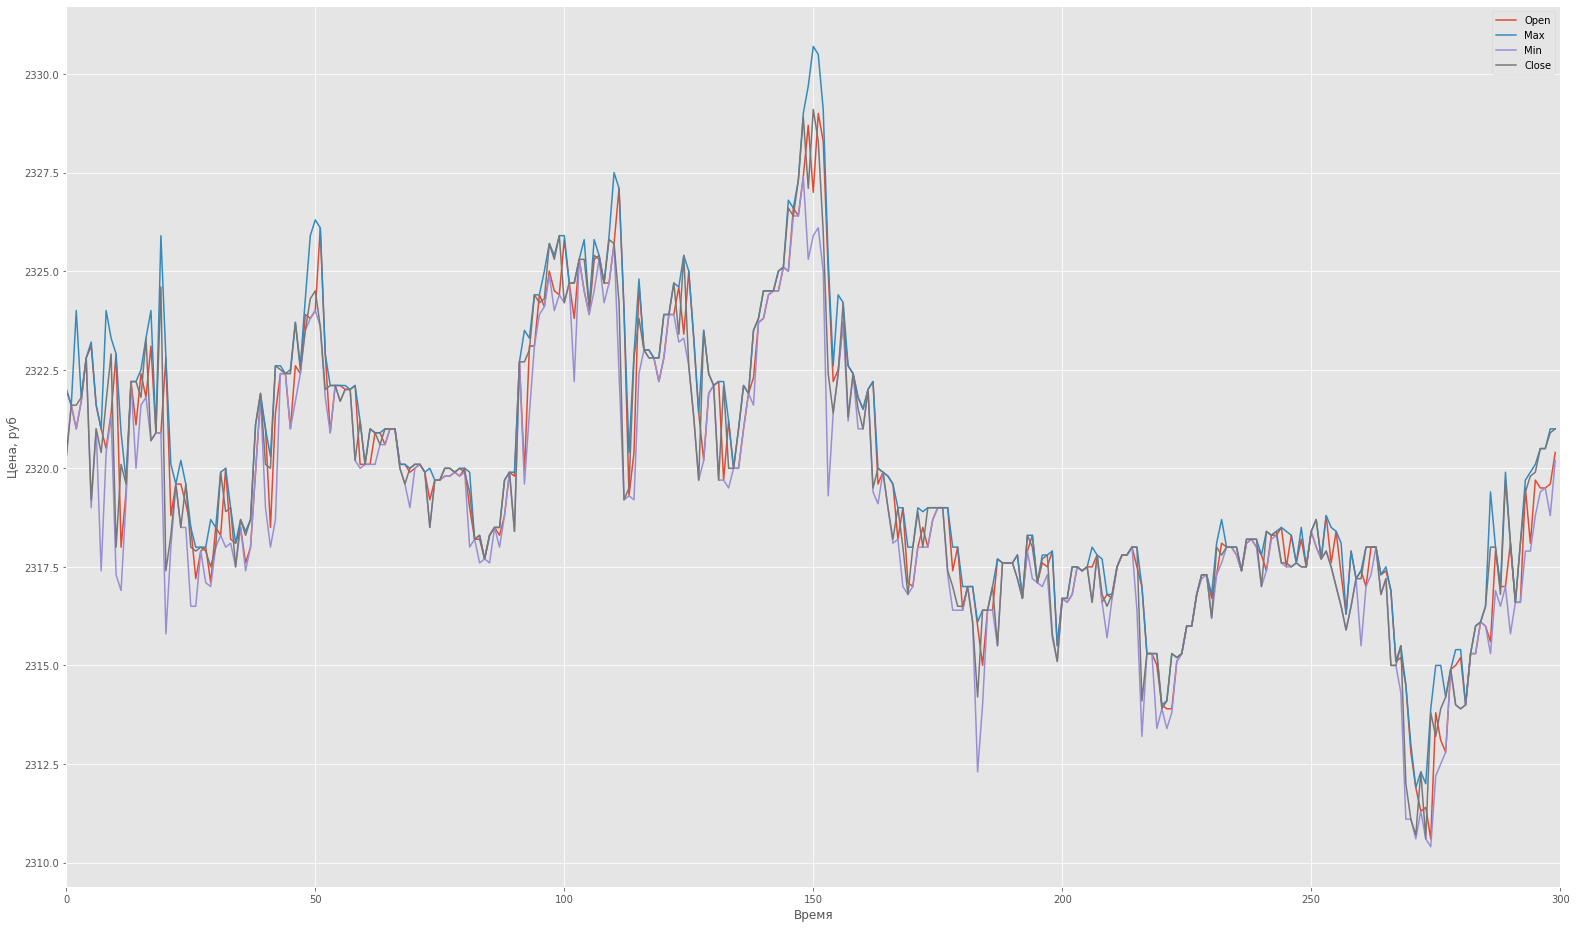

In [ ]:
# Отображение исходных данных от точки start и длинной length
start = 100
length = 300

# Задание полотна для графиков - два подграфика один под другим с общей осью x
fig, ax = plt.subplots(figsize=(22, 13), sharex=True)

# Четыре основных канала - open, max, min, close
for chn in range(4):
    # Отрисовка одного канала данных
    # От начальной точки start длиной length
    ax.plot(data[start:start + length, chn],
             label=channel_names[chn])
ax.set_ylabel('Цена, руб')
ax.legend()
plt.xlabel('Время')

# Регулировка пределов оси x
plt.xlim(0, length)

# Указание расположить подграфики плотнее друг к другу
plt.tight_layout()

# Фиксация графика
plt.show()